In [1]:
import os
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
import matplotlib.pyplot as plt
from astropy.io import fits
import torch
import numpy as np
from aion.modalities import LegacySurveyImage
import h5py
from tqdm import tqdm
import umap

2025-11-04 16:31:12.410151: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-04 16:31:12.424815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762295472.441189 3860481 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762295472.446107 3860481 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762295472.459283 3860481 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import umap
import os
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
test_file = h5py.File('../chto/astrofm/semi_supervised_test_i_snr_20.hdf5', 'r+')


In [3]:
im = test_file['images'][0,1:5,:,:]
im.shape

(4, 108, 108)

In [4]:
from aion.codecs import CodecManager

# Instantiate the manager
codec_manager = CodecManager(device="cuda")


In [5]:
from aion.model import AION

In [6]:
ims = torch.tensor(test_file['images'][:,1:5,:,:].astype('float32')).to("cuda")


In [7]:
model = AION.from_pretrained("polymathic-ai/aion-base").to("cuda")

In [8]:
from peft import LoraConfig, get_peft_model
# Helper function to count trainable parameters
def print_trainable_parameters(model):
    """Count and display trainable vs total parameters."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    
    trainable_pct = 100 * trainable_params / all_param
    print(f"  Trainable params: {trainable_params:,}")
    print(f"  Total params: {all_param:,}")
    print(f"  Trainable: {trainable_pct:.2f}%")

# Configure LoRA
lora_config = LoraConfig(
    r=10,                              # Rank (lower = fewer params)
    lora_alpha=32,                    # Scaling factor
    target_modules=["q", "proj"], # Adapt attention layers
    lora_dropout=0.1,                 # Regularization
    bias="none",                      # Don't adapt bias terms
)

# Apply LoRA to the model
print("🔄 Applying LoRA adapters to model...\n")
ft_model = get_peft_model(model, lora_config)

print("📊 Model Parameters Comparison:")
print("-" * 60)
print("Before LoRA (original model):")
print_trainable_parameters(model)
print("\nAfter LoRA (adapted model):")
print_trainable_parameters(ft_model)
print("-" * 60)
print("\n✓ LoRA adapters applied successfully!")

🔄 Applying LoRA adapters to model...

📊 Model Parameters Comparison:
------------------------------------------------------------
Before LoRA (original model):
  Trainable params: 737,280
  Total params: 314,992,896
  Trainable: 0.23%

After LoRA (adapted model):
  Trainable params: 737,280
  Total params: 314,992,896
  Trainable: 0.23%
------------------------------------------------------------

✓ LoRA adapters applied successfully!


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

In [10]:
# Custom PyTorch Dataset for protein sequences
class SequenceDataset(Dataset):
    """
    Dataset class that tokenizes protein sequences on-the-fly.
    """
    def __init__(self, df, max_length=512):
        self.df = df
        self.max_length = max_length

    def __len__(self):
        return len(self.df[0]['tok_image'])

    def __getitem__(self, idx):
        inputs = {k: v[idx] for k, v in self.df[0].items()}

        return inputs, self.df[1][idx]

print("✓ SequenceDataset class defined")

✓ SequenceDataset class defined


In [11]:
data =codec_manager.encode(LegacySurveyImage(flux=ims, bands=["DES-G", "DES-R", "DES-I", "DES-Z"]))

In [12]:
data['tok_image'].shape

torch.Size([2830, 576])

In [13]:
test_file.keys()

<KeysViewHDF5 ['decs', 'ebvs', 'features', 'features_dr', 'images', 'mags', 'mags_dr', 'objectId', 'ras', 'redshifts', 'use_redshift_1']>

In [14]:
data_numpy = {}
for key in data.keys():
    data_numpy[key]=np.array(data[key].cpu())
labels = test_file['redshifts'][:]

In [15]:
sequence = SequenceDataset([data_numpy , labels.astype(np.float32)])

In [16]:
data_numpy['tok_image'].shape

(2830, 576)

In [17]:
del ims

In [18]:
# Configuration
NSAMPLES = int(2000)  # Samples per split
SEED = 42

# Create random splits
rng = np.random.default_rng(SEED)
random_idxs = rng.choice(len(sequence), len(sequence), replace=False)

train_df = SequenceDataset(sequence[random_idxs[:NSAMPLES]])
val_df = SequenceDataset(sequence[random_idxs[NSAMPLES:int(1.1*NSAMPLES)]])
test_df = SequenceDataset(sequence[random_idxs[int(1.1*NSAMPLES):int(1.2*NSAMPLES)]])

print("✓ Data split created:")
print(f"  Train set: {len(train_df):,} samples")
print(f"  Validation set: {len(val_df):,} samples")
print(f"  Test set: {len(test_df):,} samples")

✓ Data split created:
  Train set: 2,000 samples
  Validation set: 200 samples
  Test set: 200 samples


In [19]:
train_df.df[0]['tok_image'].shape

(2000, 576)

In [20]:
device='cuda'
# Training configuration
BATCH_SIZE = 50
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
NUM_WORKERS=1

# Create custom model with regression head
class RegressionModel(nn.Module):
    """Combines LoRA-adapted ESM model with regression head."""
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model  # LoRA-wrapped model
        self.regressor = nn.Linear(768, 1)
    def forward(self, inputs):
        outputs = self.base_model.encode(inputs, num_encoder_tokens=900).mean(axis=1)
        pooled_output = outputs
        return self.regressor(pooled_output).squeeze(-1)

# Instantiate the complete model
regression_model = RegressionModel(ft_model).to(device)

print("🎯 Complete Model Architecture:")
print("-" * 60)
print_trainable_parameters(regression_model)
print("-" * 60)

# Create data loaders
tokenizer = codec_manager.encode
train_dataset = train_df
val_dataset = val_df
test_dataset = test_df

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Setup optimizer and loss
optimizer = AdamW(filter(lambda p: p.requires_grad, regression_model.parameters()), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

print("\n✓ Model and data loaders ready for training!")

🎯 Complete Model Architecture:
------------------------------------------------------------
  Trainable params: 738,049
  Total params: 314,993,665
  Trainable: 0.23%
------------------------------------------------------------

✓ Model and data loaders ready for training!


In [21]:
import torch
device_idx = 0
print(torch.cuda.device_memory_used(device_idx))

58639253504


In [22]:
torch.set_grad_enabled(True)
NUM_EPOCHS=10
# print("=" * 70)
print("🚀 STARTING LORA FINE-TUNING")
print("=" * 70)
print(f"Configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Optimizer: AdamW")
print("=" * 70 + "\n")

for ep in range(NUM_EPOCHS):
    # Training phase
    regression_model.train()
    train_loss_sum = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {ep+1}/{NUM_EPOCHS} [Train]", leave=False)
    for inputs, labels in pbar:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        preds = regression_model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    avg_train_loss = train_loss_sum / len(train_loader)
    print(f"Epoch {ep+1}/{NUM_EPOCHS} - Train Loss: {avg_train_loss:.4f}")

print("\n" + "=" * 70)
print("✓ Fine-tuning complete!")
print("=" * 70)

🚀 STARTING LORA FINE-TUNING
Configuration:
  Epochs: 10
  Batch size: 50
  Learning rate: 0.0001
  Optimizer: AdamW



Epoch 1/10 - Train Loss: 0.6854


Epoch 2/10 - Train Loss: 0.4356


Epoch 3/10 - Train Loss: 0.4137


Epoch 4/10 - Train Loss: 0.3926


Epoch 5/10 - Train Loss: 0.3629


Epoch 6/10 - Train Loss: 0.3504


Epoch 7/10 - Train Loss: 0.3468


Epoch 8/10 - Train Loss: 0.3484


Epoch 9/10 - Train Loss: 0.3464


Epoch 10/10 - Train Loss: 0.3422

✓ Fine-tuning complete!


In [23]:
# Evaluate on test set
print("🔄 Evaluating on test set...\n")
regression_model.eval()
test_predictions = []

for inputs, labels in tqdm(test_loader, desc="Testing"):
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        preds = regression_model(inputs).cpu().numpy()
        test_predictions.extend(preds)
test_predictions = np.array(test_predictions)


🔄 Evaluating on test set...



Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.26it/s]


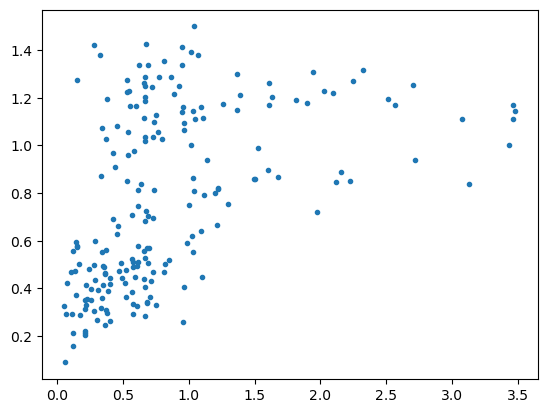

In [25]:
plt.plot(test_df.df[1], test_predictions, ".")